In [1]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.cnnlstm import CNNLSTMModel
from src.training_utils import *
from src.tuning_utils import *
import optuna

In [2]:
# define data directory
data_dir = '../data/'

In [3]:
# load data
data = load_data(data_dir)

# split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

Number of samples: 13388
--------------------
Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)
--------------------
X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

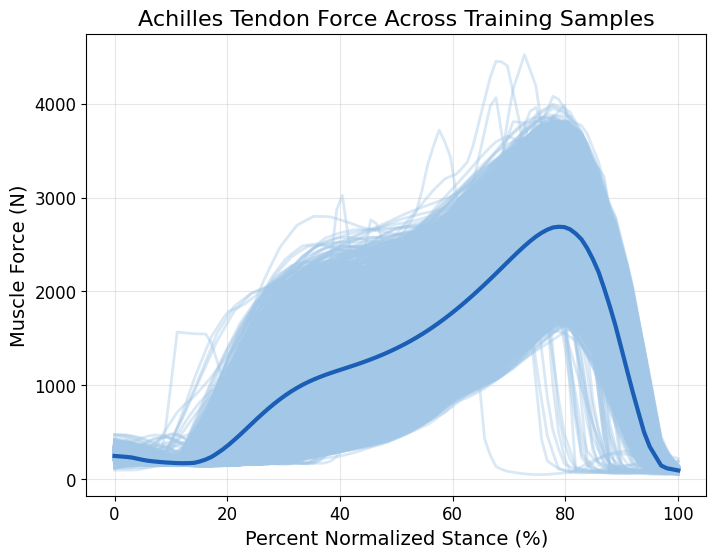

In [4]:
# plot data to double check
plot_achilles_force(y_train)

In [5]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [6]:
# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [7]:
def objective(trial, train_dataset, val_dataset, device):
    """
    Optuna objective function for hyperparameter optimization.
    
    Args:
        trial: Optuna trial object.
        train_dataset: Training dataset.
        val_dataset: Validation dataset.
        device: Device to use for training.
    
    Returns:
        float: Best validation loss for this trial.
    """
    # Sample hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 3, step=1)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, log=False)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    regularization = trial.suggest_float('regularization', 1e-5, 1e-2, log=True)
    
    # Prepare model parameters
    model_params = {
        'input_size': 3,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': 9
    }
    
    # Train and evaluate
    best_val_loss, _ = train_eval_optuna(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        model_class=CNNLSTMModel,
        model_params=model_params,
        learning_rate=learning_rate,
        batch_size=batch_size,
        regularization=regularization,
        device=device,
        num_epochs=500,
        patience=10,
        verbose=False
    )
    
    return best_val_loss


# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, train_dataset, val_dataset, device),
    n_trials=100
)

print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

[I 2025-12-01 14:54:03,270] A new study created in memory with name: no-name-c833002e-ccb7-46bb-b058-691e24a4507a
[I 2025-12-01 15:06:31,561] Trial 0 finished with value: 240031.01525130792 and parameters: {'hidden_size': 32, 'num_layers': 3, 'dropout_rate': 0.14470842698759967, 'learning_rate': 1.590223280843782e-05, 'batch_size': 32, 'regularization': 4.3581590944986144e-05}. Best is trial 0 with value: 240031.01525130792.
[I 2025-12-01 15:17:50,199] Trial 1 finished with value: 55072.01488345478 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.3390857386004106, 'learning_rate': 0.0002207595769548366, 'batch_size': 32, 'regularization': 6.783906777367189e-05}. Best is trial 1 with value: 55072.01488345478.
[I 2025-12-01 15:30:20,658] Trial 2 finished with value: 186550.90146207027 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout_rate': 0.023963868756730233, 'learning_rate': 2.8041974176772096e-05, 'batch_size': 64, 'regularization': 0.0003060251942

Best hyperparameters: {'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.3853185122456446, 'learning_rate': 0.0007215808014600761, 'batch_size': 32, 'regularization': 0.0014974479323470987}
Best validation loss: 1443.554443359375


In [8]:
# Create test dataset
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [9]:
# Train the final model with the best hyperparameters
best_model, results = train_final_model(
    train_dataset=train_dataset, 
    val_dataset=val_dataset,
    test_dataset=test_dataset, 
    model_class=CNNLSTMModel,
    best_params=study.best_params,
    device=device,
    num_epochs=1000,
    patience=20,
    save_path='../models/cnn-lstm_v2.pth'
)

Training final model with best hyperparameters:
hidden_size: 256
num_layers: 3
dropout_rate: 0.3853185122456446
learning_rate: 0.0007215808014600761
batch_size: 32
regularization: 0.0014974479323470987
Epoch [10/1000], Train Loss: 141928.0261, Val Loss: 137707.9590
Epoch [20/1000], Train Loss: 70055.4408, Val Loss: 67984.9608
Epoch [30/1000], Train Loss: 30878.6616, Val Loss: 29930.5135
Epoch [40/1000], Train Loss: 12052.4284, Val Loss: 11759.6387
Epoch [50/1000], Train Loss: 4473.0579, Val Loss: 4904.4027
Epoch [60/1000], Train Loss: 2279.3392, Val Loss: 2523.9909
Epoch [70/1000], Train Loss: 1442.3235, Val Loss: 2009.1325
Epoch [80/1000], Train Loss: 1285.4640, Val Loss: 1781.0900
Epoch [90/1000], Train Loss: 984.4991, Val Loss: 1657.0236
Epoch [100/1000], Train Loss: 890.0556, Val Loss: 1576.3616
Epoch [110/1000], Train Loss: 771.6637, Val Loss: 1509.0371
Epoch [120/1000], Train Loss: 702.4789, Val Loss: 1525.8812
Early stopping at epoch 126
Final Model Results:
Training Loss:   617

In [10]:
# Test the model and get predictions for plotting
criterion = nn.MSELoss()
test_loss, test_outputs, test_targets = test_final_model(
    model=best_model,
    test_dataset=test_dataset,
    batch_size=study.best_params['batch_size'],
    criterion=criterion,
    device=device
    )

Final Model Results:
Test Loss:       1470.445383


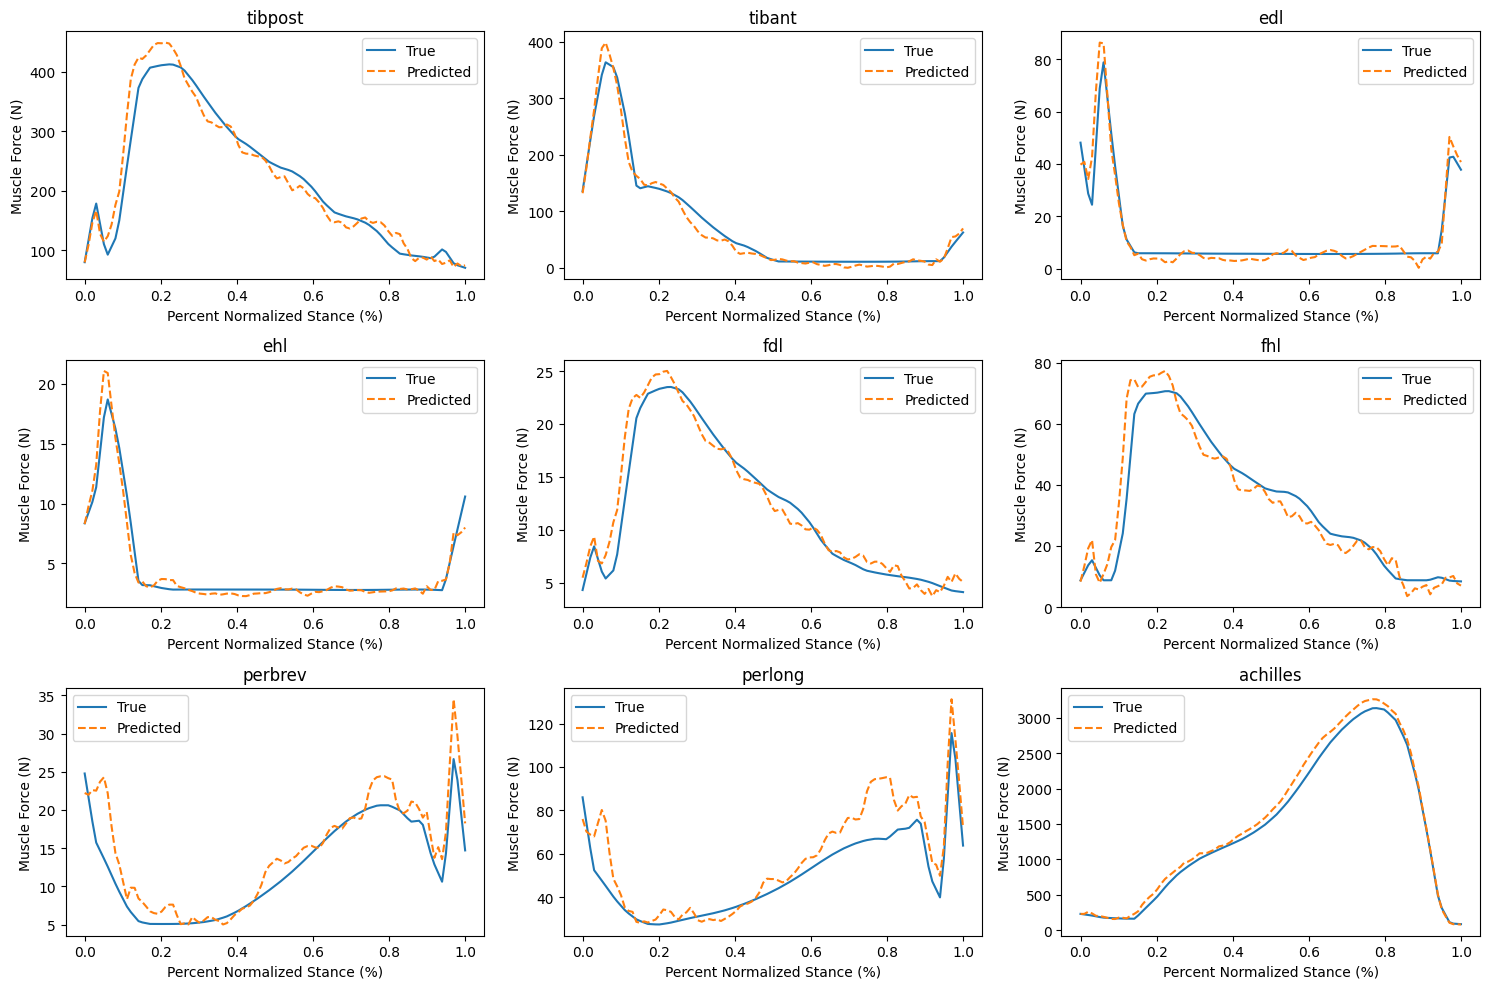

In [11]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)